In [1]:
%pip install XlsxWriter
# https://qiskit.org/documentation/getting_started.html
%pip install qiskit[visualization]

  Using cached XlsxWriter-3.0.9-py3-none-any.whl (152 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import qiskit
from qiskit import assemble, QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit.compiler import transpile
from random import *
from qiskit import Aer
sim = Aer.get_backend("statevector_simulator")
import numpy as np
from qiskit.circuit.library.standard_gates import HGate
from qiskit.circuit.library import RZGate, RYGate
import matplotlib.pyplot as plt

import time
from IPython.display import clear_output

In [2]:
def neighbor_list(i, j, N):
  a = i-1
  b = j-1
  c = i+1 
  d = j+1 
  if a < 0: 
      a = N-1
  if b < 0: 
      b = N-1
  if c > N-1: 
      c = 0 
  if d > N-1: 
      d = 0
  left   = (a, j)
  above  = (i, b)
  right  = (c, j)
  below  = (i, d)
  return [left, above, right, below]

In [3]:
def lat_qc(i, temp): 
    global N
    spin = N**2

    prob1= np.exp(-8/temp)
    angle1 = 2*np.arccos(np.sqrt(prob1))
    prob2 = np.exp(-4/temp)
    angle2 = 2*np.arccos(np.sqrt(prob2))

    ### construct neighbor qubit 
    ising = np.arange(0, N**2).reshape(N,N)
    index = np.where(i==ising)
    neighbor_qubit = []
    for k in neighbor_list(index[0], index[1],N):
        neighbor_qubit.append(ising[k][0])
    ### construct circuit 
    qc = QuantumCircuit(spin+4, spin)
    aux_qubit = [spin, spin+1, spin+2, spin+3]
    # flip first 
    qc.x(i)
    qc.barrier()

    # store sign information
    for j in range(4): 
        qc.cx(i, aux_qubit[j])
        qc.cx(neighbor_qubit[j], aux_qubit[j])

    # rotate or not depends on sign
    #####################situation 1 : all same signs #####################
    [aux1, aux2, aux3, aux4] = aux_qubit
    # default is ferromagnetic
    mcry= RYGate(angle1).control(4,label=None )
    # for antiferromagnetic add the line below
    # mcry._ctrl_state=0
    qc.append(mcry,[aux1, aux2, aux3, aux4, i])

    #####################situation 2 : 3 same(different) signs, 1 different (same) signs #####################
    # implementation (entanglement) will be different depends on the system is FM or AFM 
    mcry_1= RYGate(angle2).control(4,label=None )
    mcry_2= RYGate(angle2).control(4,label=None )
    mcry_3= RYGate(angle2).control(4,label=None )
    mcry_4= RYGate(angle2).control(4,label=None )

    # ferromagnetic  
    mcry_1._ctrl_state=14
    mcry_2._ctrl_state=13
    mcry_3._ctrl_state=11
    mcry_4._ctrl_state=7

    # antiferromagnetic 
    # mcry_1._ctrl_state=1
    # mcry_2._ctrl_state=2
    # mcry_3._ctrl_state=4
    # mcry_4._ctrl_state=8

    qc.append(mcry_1, [aux1, aux2, aux3, aux4, i])
    qc.append(mcry_2, [aux1, aux2, aux3, aux4, i])
    qc.append(mcry_3, [aux1, aux2, aux3, aux4, i])
    qc.append(mcry_4, [aux1, aux2, aux3, aux4, i])
    qc.barrier()
    # measure
    for i in range(spin): 
        qc.measure(i,i)
    return qc

def get_2d_qc(spin, temp):  
    # get all possible circuit
    qc_info=[]
    for i in range(spin):
        qc_info.append(lat_qc(i, temp))
    return qc_info
def measure_state(qc, sim): 
    qc = transpile(qc,sim)
    final_counts = sim.run(qc, shot=1).result().get_counts()
    return final_counts.keys()

def map_state(final_state, spin):
    state = np.zeros(spin)
    for i in final_state:
        for j,k in enumerate(i): 
            if k == '1': 
                state[j] = k 
    return state
    
def magnetization(eq_state):
    ans = 0
    size = len(eq_state)
    for num in eq_state:
        if num == '1':
            ans += 1
        elif num == '0':
            ans -= 1
    return abs(ans)/float(size)    

def MC_sweep_2D(start, runs, qc_info, sim):
    global spin, N
    qc = start
    # pyplot.figure(figsize=(5,5))
    plt.ion()
    states = []
    mag = []
    times = []
    for run in range(runs):
        tic = time.time()
        # randomly pick site
        pick = randint(1, spin)
        circuit = qc_info[pick-1]
        qc.compose(circuit, inplace=True)
        # print(qc)
        state = measure_state(qc,sim)
        toc = time.time()
        time_taken = toc - tic
        
        state_string = list(state)[0]
        states.append(state_string)
        mag.append(magnetization(state_string))
        times.append(time_taken)
        # run the next MC with previous state
        qc = QuantumCircuit(spin+4, spin)
        
       
        clear_output(wait=True)
        plt.imshow(map_state(state, spin).reshape(N,N))
        # pyplot.show()
        plt.show()
    
        for i in state: 
            for j, k in enumerate(i): 
                if k == '1': 
                    qc.x(spin-1-j)
    return states, mag, times

In [4]:
# global information
N = 4
spin = N**2

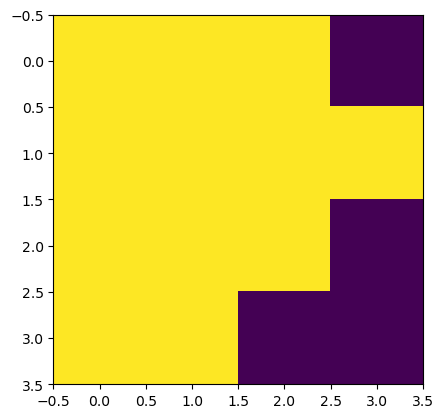

In [5]:

import pandas as pd
writer1 = pd.ExcelWriter('FM Monte Ca rlo 4x4p long1.xlsx', engine = 'xlsxwriter')
writer2 = pd.ExcelWriter('FM Monte Carlo 4x4p iterations long1.xlsx', engine = 'xlsxwriter')
data1 = pd.DataFrame()
data2 = pd.DataFrame()

# FM ensemble average
temps = np.linspace(0.01, 40, 45)
temps = temps[:15]
mag_values = []
std_values = []
execution_time = []
for temp in temps:
    info = get_2d_qc(spin,temp)
    cold_lat = QuantumCircuit(spin+4, spin)
    # equilibrium run : 1024
    states, mag, times = MC_sweep_2D(cold_lat, 10000, info, sim)
    mag_values.append(np.mean(mag))
    std_values.append(np.std(mag))
    execution_time.append(np.sum(times))
    data2['temp='+str(temp)] = mag

data1['Magnetization'] = mag_values
data1['Standard Deviation'] = std_values
data1['time (s)'] = execution_time
data1.to_excel(writer1)
data2.to_excel(writer2)
writer1.save()
writer2.save()